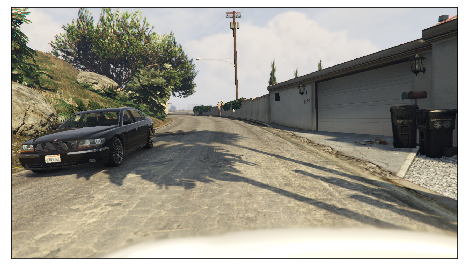

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container{max-width:80%!important;width:auto!important;}</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

from tqdm.notebook import tqdm, trange

import sys
sys.path.append('../')

from depth_Functions import (
    show_img,
    show_array_of_images,
    show_function,
    import_raw_colour_image
)

from Feature_Extraction import (
    mask,
    texture_variation,
    haze,
    create_kernels,
    denoise,
    texture_gradients,
    get_thresholds,
    create_local_feature_vector
)

from Patches import Patches

bgr = import_raw_colour_image('../GTA_images/Simple/Colour/color_1.raw')
show_img(bgr);

# Theory

In accordance with [3-D Depth Reconstruction from a Single Still Image](https://www.cs.cornell.edu/~asaxena/learningdepth/ijcv_monocular3dreconstruction.pdf) we need to get the feature vector of a patch.

We obtain a vector of length 34. A standard and squared version of:

1. 9 texture variations:
    - Each texture variation is obtained using one of the 9 Laws' masks of the intensity
1. 2 Haze variations:
    - 1st Laws' mask applied to the red difference and blue difference
1. 6 texture gradients:
    - Edge detection at angle intervals of $30^\circ$

# YCbCR

Convert the image from BGR to YCrCb:
1. Y: Intensity (luminance)
1. Cr: Red difference
1. Cb: Blue difference

In [97]:
show_function(Patches.show_channels)

def show_channels(channels=None, *args, **kwargs):
        if channels is None:
            channels = [i for i in range(self.image.shape[-1])]

        show_array_of_images([self.image[...,i] for i in channels], *args, **kwargs)

In [1]:
ycc = cv2.cvtColor(bgr, cv2.COLOR_BGR2YCrCb) 

show_array_of_images([ycc], heatmap=True, split_channels=True,
                     titles=['Intensity', 'Red difference', 'Blue difference'])

NameError: name 'cv2' is not defined

As we'll be carrying out different implementations on each channel, we'll separate them into different arrays

# Laws' Mask 

[Based on](https://courses.cs.washington.edu/courses/cse455/09wi/Lects/lect12.pdf)

In [7]:
filters = [
                np.array([ 1,  4,  6,  4,  1]),
                np.array([-1, -2,  0,  2,  1]),
                np.array([-1,  0,  2,  0, -1]),
                np.array([ 1, -4,  6, -4,  1])
               ] 


show_function(mask)
show_function(haze)

def mask(patch, first, second=None):
    if second is None:
        return cv2.filter2D(patch, -1, filters[first].reshape(5,1)*filters[first])
    else:
        filter1 = cv2.filter2D(patch, -1, filters[first].reshape(5,1)*filters[second])
        filter2 = cv2.filter2D(patch, -1, filters[second].reshape(5,1)*filters[first])
        return (filter1 + filter2)/2

def haze(cr, cb):
    return [mask(cr, 0, 1), mask(cb, 0, 1)]

In [129]:
y, cr, cb = cv2.split(cv2.cvtColor(ycc, cv2.COLOR_BGR2YCrCb))

In [130]:
laws = texture_variation(y) + haze(cr, cb)

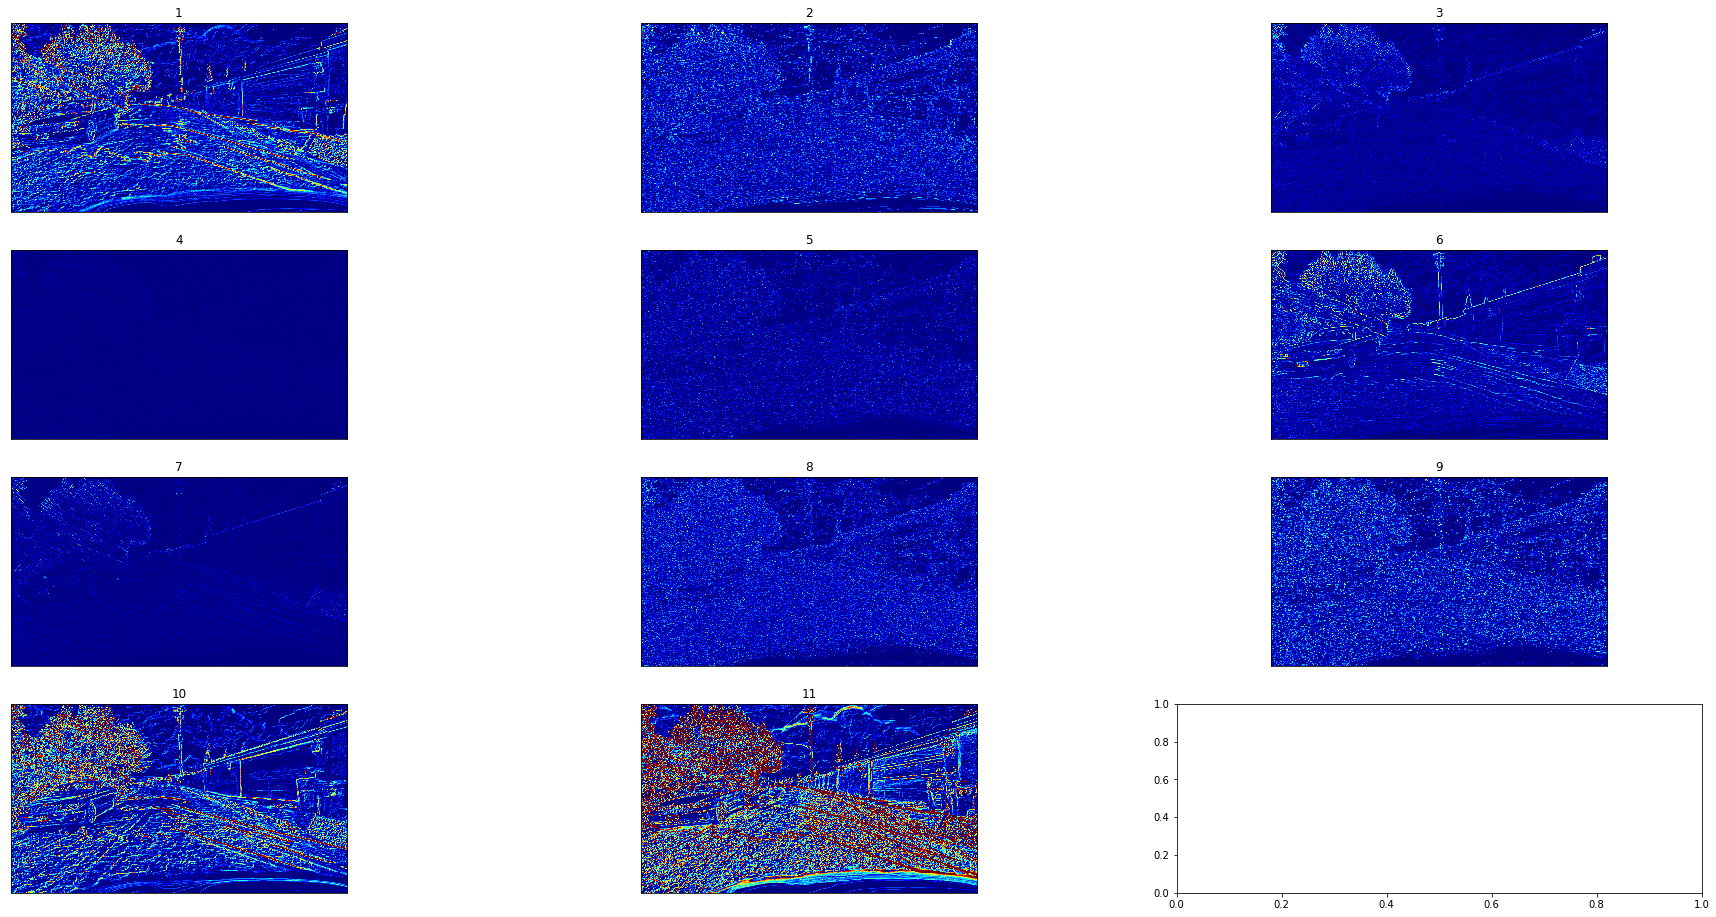

In [131]:
show_array_of_images(laws, figsize=(16,32), heatmap=True,
                     titles=[i for i in range(1,12)])

# Edge detection

The angle the edge detector registers the change in gradient is determined by the kernel.

In [52]:
show_function(create_kernels)

def create_kernels(step=90, min=0, max=180):
    kernels = []
    
    for angle in range(min,max,step):
        rad = math.radians(angle)
        cos = round(math.cos(rad),2)
        sin = round(math.sin(rad),2)
        kernels.append(np.array([
                                    [sin-cos,   2*sin, cos+sin],
                                    [-2*cos,        0,   2*cos],
                                    [-sin-cos, -2*sin, cos-sin] 
                                ]))
    
    return kernels

[OpenCV canny edge detection](https://github.com/opencv/opencv/blob/master/modules/imgproc/src/canny.cpp) is predetermined to combine vertical and horizontal edge detection with no means to input custom kernels. So use our own implementation, [based on a tutorial by towards datascience](https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123).

In [209]:
show_function(texture_gradients)

def texture_gradients(patch, *args, **kwargs):
    kernels = create_kernels(*args, **kwargs)
    gradients = []
    
    for kernel in kernels:
        gradients.append(ndimage.filters.convolve(patch, kernel))
        
    return gradients

In [54]:
edges = texture_gradients(y, step=30)

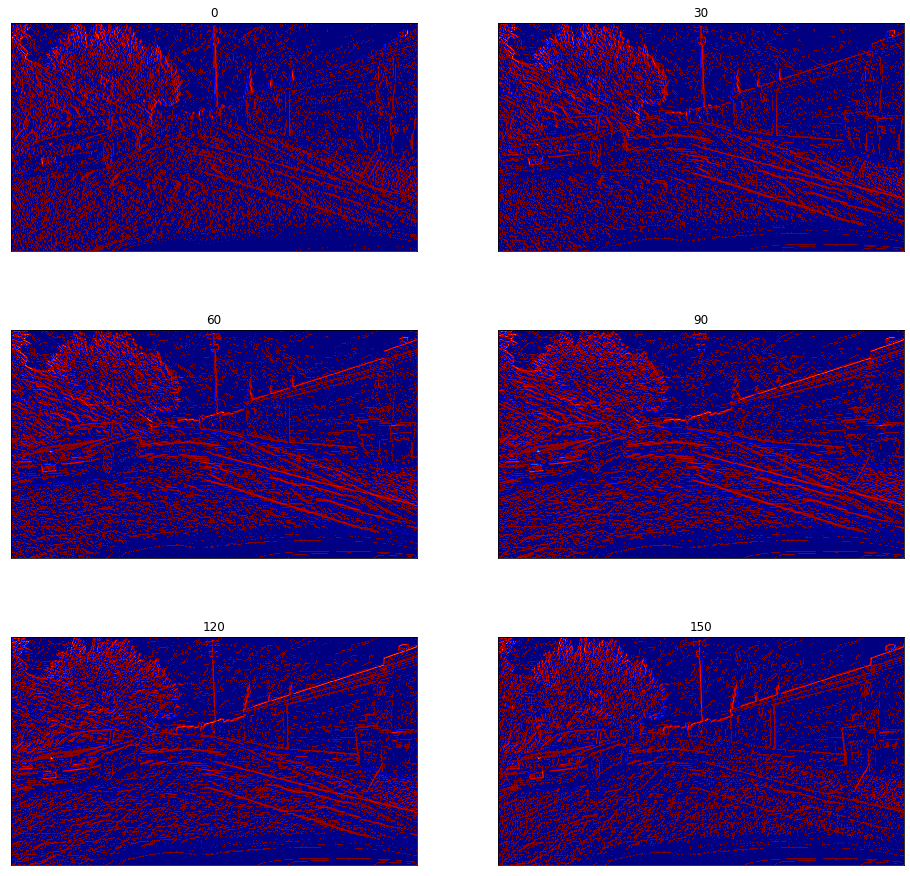

In [55]:
show_array_of_images(edges, heatmap=True,
                     titles = [i for i in range(0,180,30)])

In [11]:
show_function(create_local_feature_vector)

def create_local_feature_vector(patch, squares=True, function=np.sum):
    vector = []
    y, cr, cb = cv2.split(cv2.cvtColor(patch, cv2.COLOR_BGR2YCrCb))
    
    vector = texture_variation(y) 
    vector += haze(cr, cb)
    vector += texture_gradients(y, step=30)

    if not squares:
        return np.array([function(feature) for feature in vector])

    vector += [feature**2 for feature in vector]

    return np.array([function(feature) for feature in vector])

# Separating the image into patches

For this we will create a Patch function that stores:
1. The original image (which may be converted to another set of channels)
1. The width and height of the patches, which is readjusted to be an equdistant accross the image
1. The number of pathces up and accross

In [28]:
show_function(Patches.__init__)

def __init__(self, image, patchsize, feature_shape, convert=None, 
                 scales=[(1,1)], neighbour_order = [(0,0)], *args, **kwargs):
        if convert is None:
            self.image = image
        else :
            self.image = cv2.cvtColor(cv2.GaussianBlur(image, (5, 5), 0), convert)
        
        self.__get_patchsize(patchsize)
        self.nxm = [int(i_dim / p_dim) for i_dim, p_dim in zip(image.shape, self.patchsize)]
        self.patches = np.zeros((len(scales), *image.shape[:2], len(neighbour_order), *feature_shape))
        self.scales = scales
        self.neighbour_order  = neighbour_order
        print(f'patchsize = {self.patchsize}')
        print(f'nxm = {self.nxm}')
        self.show_channels(*args, **kwargs)

patchsize = [6, 8]
nxm = [120, 160]


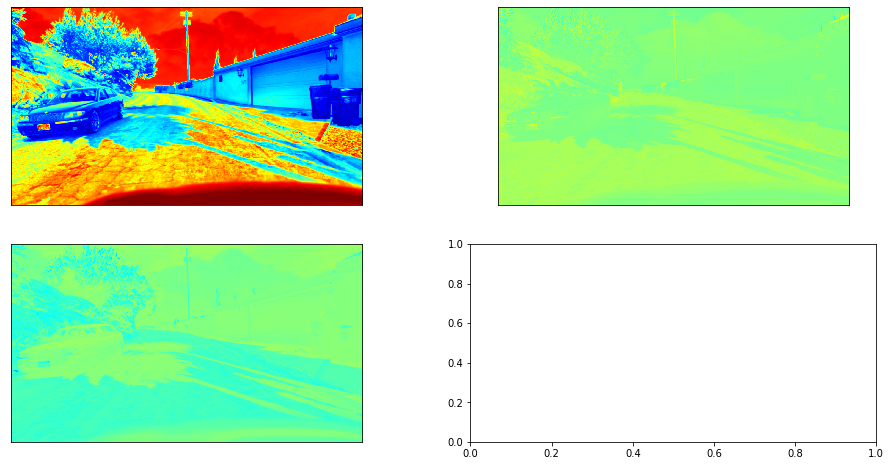

In [3]:
patches = Patches(image=bgr, patchsize=6, feature_shape=(34,), convert=cv2.COLOR_BGR2YCrCb, split_channels=True, heatmap=True)

## Getting local absolute depth for each patch

We use a Patches' process image function to carry out the given function for each patch

In [11]:
show_function(Patches.process_image)

def process_image(self, function=lambda x: x, scale=(1,1), name=''):
        if scale == (1,1):
            image = self.image
        else:
            image = cv2.resize(image, (0,0), fy=scale[0], fx=scale[1])
        
        heights = [y for y in range(0,self.image.shape[0],scale[0]*self.patchsize[0])]
        widths  = [x for x in range(0,self.image.shape[1],scale[1]*self.patchsize[1])]

        for y, (y0,y1) in tqdm(enumerate(zip(heights, heights[1:])), 
                               total=len(heights)-1, leave=False, desc=name):
            for x, (x0,x1) in enumerate(zip(widths, widths[1:])):
                self.patches[scale, y, x] = function(image[y0:y1, x0:x1])

To get the local features we carry out the create_local_feature_vector function.

In [12]:
show_function(create_local_feature_vector)

def create_local_feature_vector(patch, squares=True, function=np.sum):
    y, cr, cb = cv2.split(patch)
    vector = []
    vector = texture_variation(y) 
    vector += haze(cr, cb)
    vector += texture_gradients(y, step=30)

    if not squares:
        return np.array([function(feature) for feature in vector])

    vector += [feature**2 for feature in vector]

    return np.array([function(feature) for feature in vector])

In [5]:
patches.patches.shape

(1, 120, 160, 1, 34)

In [6]:
patches.process_image(function=create_local_feature_vector)

In [20]:
show_img(patches.patches[0,[0],[0],0,0].repeat(6,axis=0).repeat(8,axis=1))

AxisError: axis 1 is out of bounds for array of dimension 1

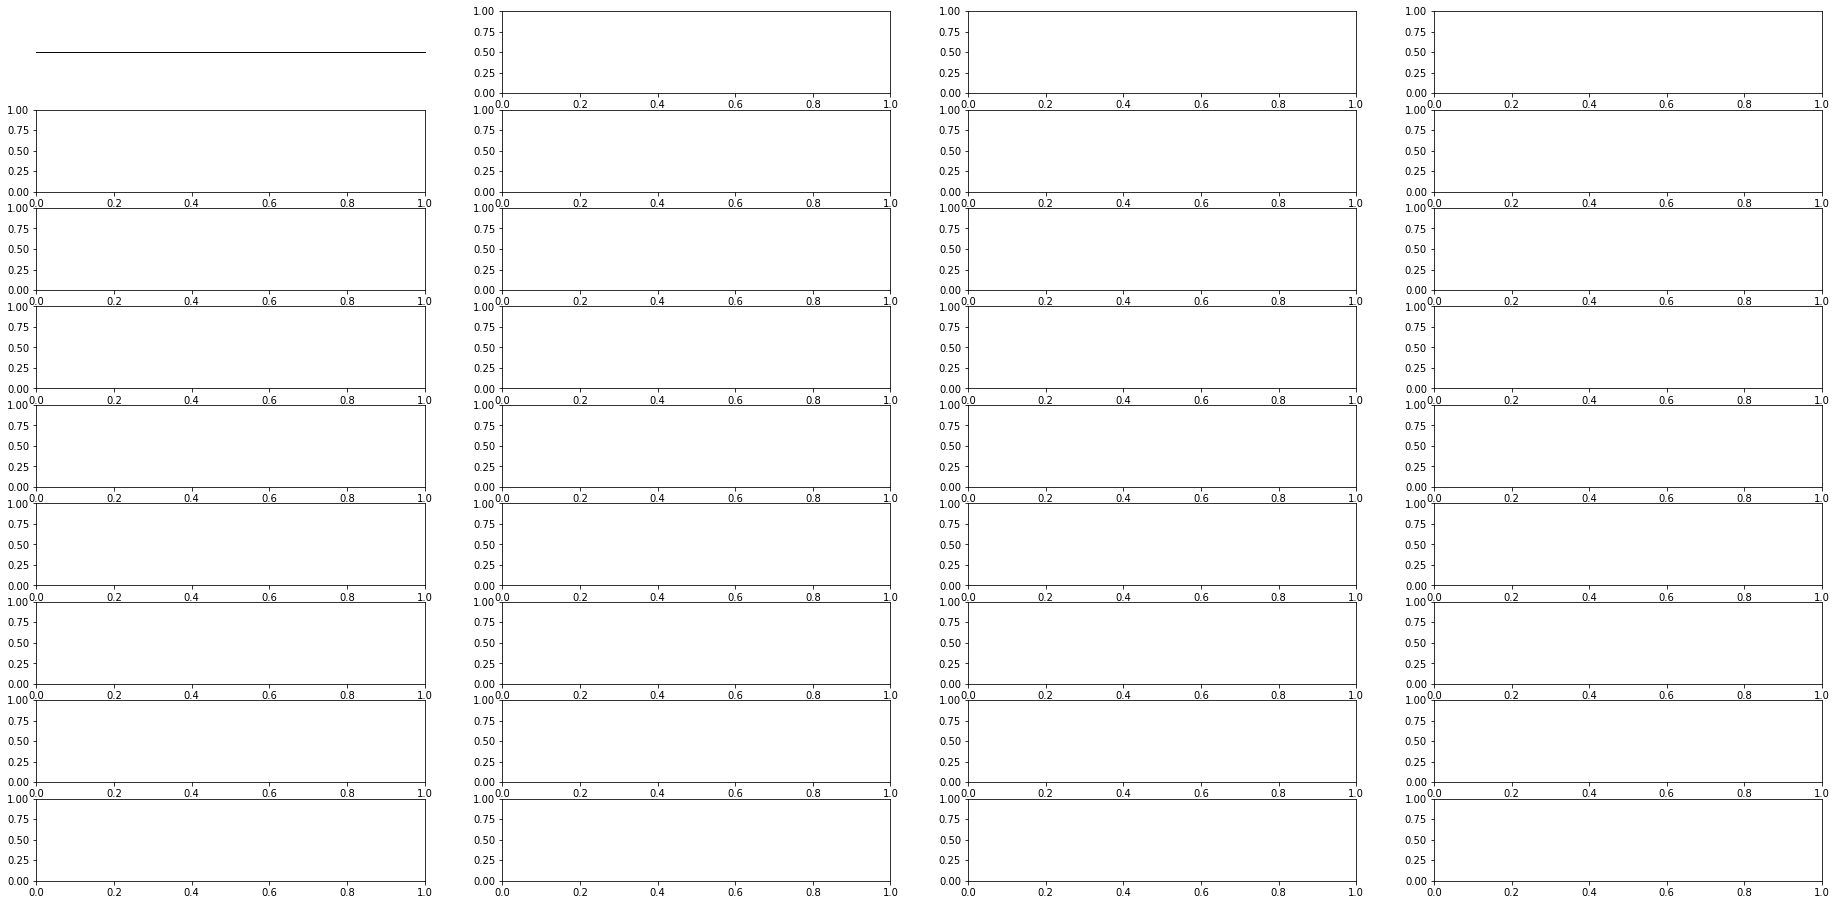

In [23]:
patches.show_patches(heatmap=True, image_array_shape=(9,4), figsize=(16,32))